In [2]:
from l0pca import weights_utility

2022-10-28 16:45:24.837954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import numpy as np
import tensorflow as tf
data = np.loadtxt('Buettner2015Features@1024.csv', delimiter=',', dtype='object')
gene_names = data[0, 1:]
data = data[1:, 1:].astype(np.float32)
data = tf.constant(data)
cov = tf.linalg.matmul(tf.transpose(data), data) / (data.shape[0] - 1)

In [10]:
gene_names[[109, 410, 1020]]

array(['"ENSMUSG00000008668"', '"ENSMUSG00000025794"',
       '"ENSMUSG00000093674"'], dtype=object)

In [12]:
np.linalg.eigh(cov.numpy()[[109, 410, 1020]].T[[109, 410, 1020]])[0]

array([0.06699303, 0.08763904, 2.8558207 ], dtype=float32)

In [871]:
@tf.function(jit_compile = True)
def gather_cov(cov, batches):
    inds_row = batches[..., :, None, None]
    inds_col = batches[..., None, :, None]
    inds_shape = tf.broadcast_dynamic_shape(
        tf.shape(inds_row), tf.shape(inds_col))
    inds = tf.concat([tf.broadcast_to(inds_row, inds_shape), tf.broadcast_to(inds_col, inds_shape)], axis=-1)
    return tf.gather_nd(cov, inds)

In [872]:
tf.gather_nd(cov, [[[1, 1], [1, 3]], [[3, 1], [3, 3]]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.0034844 , 0.46886358],
       [0.46886358, 1.0034841 ]], dtype=float32)>

In [462]:
@tf.function(jit_compile = True)
def reservoir_sample_naive(k, weights):
    order = tf.random.shuffle(tf.range(weights.shape[0]))
    weights = tf.gather(weights, order)
    retain = weights < tf.random.uniform(weights.shape)
    return tf.ensure_shape(tf.boolean_mask(order, retain)[:k], [k])

In [511]:
reservoir_sample_naive(3, tf.constant([0.1, 0.1, 0.1, 0.7]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 1, 0], dtype=int32)>

In [875]:
def evaluate_cov(weights, cov, k):
    ensemble_prob = tf.nn.softmax(weights)
    ensemble = reservoir_sample_naive(k, ensemble_prob)
    ensemble_cov = gather_cov(cov, ensemble)

    loss = tf.math.reduce_max(
        tf.linalg.eigh(ensemble_cov)[0],
    )

    data_no_conflict = tf.logical_not(
        tf.reduce_any(
            tf.equal(tf.range(cov.shape[0])[:, None], ensemble[None, :]),
            axis=-1))
    data_list = tf.boolean_mask(tf.range(cov.shape[0]), data_no_conflict)
    data_row = tf.gather(cov, ensemble)
    data_row = tf.gather(tf.transpose(data_row),
                  data_list)[:, None, :]
    data_diag = tf.gather(tf.linalg.diag_part(cov), data_list)

    cov_batch_shape = tf.broadcast_dynamic_shape(tf.shape(ensemble_cov[None, :, :]), tf.shape(data_row))
    ensemble_aug = tf.concat(
        [
            tf.concat(
                [
                    tf.broadcast_to(
                        ensemble_cov[None, :, :],
                        cov_batch_shape),
                    transpose_simple(data_row),
                ],
                axis=2,
            ),
            tf.concat(
                [
                    data_row,
                    data_diag[:, None, None],
                ],
                axis=2,
            ),
        ],
        axis=1,
    )
    eigenvalues, eigenvectors = tf.linalg.eigh(ensemble_aug)
    pc0 = tf.gather(transpose_simple(eigenvectors), tf.argmax(eigenvalues, axis=1), batch_dims=1)
    ranking = tf.argsort(tf.math.abs(pc0), axis=1)
    aug_index = k
    next_feature = tf.where(
        ranking[:, 0] == aug_index,
        ranking[:, 1],
        ranking[:, 0])
    score = tf.math.abs(pc0[:, -1]) - tf.math.abs(tf.gather(pc0, next_feature, batch_dims=1))
    updates = tf.where(score > 0, tf.math.log(score), 0)
    return loss, data_list, updates

In [768]:
class AnnealingDiffEq(object):
    def __init__(self, t0):
        self.t0 = t0

    def temperature(self, i):
        return self.t0 / tf.math.log(i + 2)

    def compute_derivative(self, temperature):
        """Applies a first-order diff eq: `y' = f(y)`.

        The derivative `dt/di` (thermodynamic temperature - reciprocal) is:
        `t0 / (i + e)`. Then: `t' = t0 exp(-t / t0)`. All updates ("gradient")
        must be adjusted so that they are the difference between a new vector
        with the expected updated L1 norm, and the original vector. Otherwise,
        we would not step through annealing at the expected schedule.
        """
        return self.t0 * tf.math.exp(-temperature / self.t0)

class ParameterStrategy(object):
    def __init__(self, t0) -> None:
        self.annealing_diff_eq = AnnealingDiffEq(t0)

    def call(self, param, evaluation_fn):
        @tf.custom_gradient
        def custom_gradient_impl(param):
            def grad(upstream, variables=[]):
                # variables (cov) are unused.
                variables = list(map(tf.zeros_like, variables))
                unused_loss, update_ind, update_score = evaluation_fn(param)
                return upstream * self._update_scatter_backprop(param, update_ind, update_score), variables

            return evaluation_fn(param)[0], grad

        return custom_gradient_impl(param)

    def _update_scatter_backprop(self, param, update_ind, update_score):
        @tf.function
        def update_impl(param, update_ind, update_score, annealing_diff_eq):
            temperature = tf.linalg.norm(param, 1)
            updated_temperature = temperature + annealing_diff_eq.compute_derivative(temperature)
            orig_param = param
            param = tf.tensor_scatter_nd_add(
                param,
                update_ind[:, None],
                update_score,
            )
            # return -(param * updated_temperature / tf.linalg.norm(param, 1) - orig_param)
            return -(param - orig_param)
        return update_impl(param, update_ind, update_score, self.annealing_diff_eq)

In [769]:
from ast import Param
import tensorflow as tf
from l0pca import weights_utility

class L0PCALayer(tf.keras.layers.Layer):
    def __init__(self, t0=1) -> None:
        super().__init__()
        self.t0 = float(t0)
        self.parameter_strategy = ParameterStrategy(self.t0)

    def build(self, input_shape):
        self.feature_logits = self.add_weight(
            'feature_logits',
            shape=[input_shape[1]],
            initializer=lambda shape, dtype: tf.fill(shape, tf.constant(self.t0 / shape[0], dtype)),
            trainable=True,
        )
        self.cov_matrix = self.add_weight(
            'cov_matrix',
            shape=[input_shape[1], input_shape[1]],
            initializer='zero',
            trainable=False,
        )
        self.epoch = self.add_weight(
            'epoch',
            shape=[],
            initializer='zero',
            dtype=tf.int32,
            trainable=False,
        )

    def call(self, data):
        data = data - tf.math.reduce_mean(data, axis=0)[None, :]
        cov_matrix = tf.cond(
            tf.equal(self.epoch, 0),
            lambda: self.cov_matrix.assign(tf.linalg.matmul(tf.transpose(data), data)),
            lambda: self.cov_matrix)
        self.epoch.assign_add(1)
        return self.parameter_strategy.call(
            self.feature_logits,
            lambda param: evaluate_cov(param, cov_matrix, 12))

class L0PCA(tf.keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer = L0PCALayer()

    def call(self, data):
        result = self.layer(data)
        self.add_loss(result)
        return result

In [770]:
tf.keras.backend.clear_session()

In [771]:
tf.config.optimizer.set_jit(True) # Enable XLA.

In [887]:
m = L0PCA()

In [877]:
# Other optimizers not showing as good of a gene set!
opt = tf.keras.optimizers.SGD(1e-3)
opt = tf.keras.optimizers.Adam(1e-1)

In [888]:
m.compile(opt, steps_per_execution=1)

In [889]:
tf.debugging.disable_traceback_filtering()

In [890]:
m.fit(data, epochs=1)

9/9 [==============================] - 1s 94ms/step - loss: 224.6059


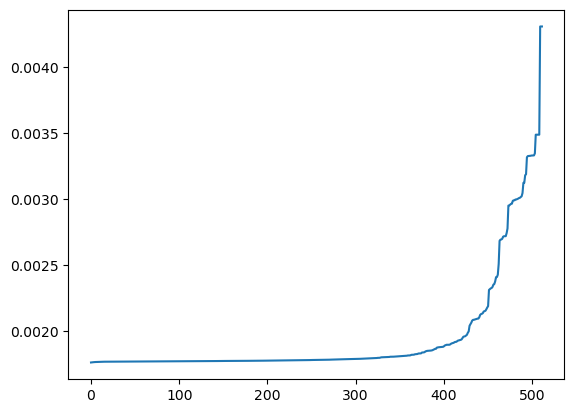

In [884]:
plt.plot(np.sort(tf.nn.softmax(m.weights[0])))

In [853]:
(tf.nn.softmax(m.weights[0]) > 0.0001).numpy().sum()

9

In [854]:
np.argmax(m.weights[0])

50

In [855]:
gene_names[np.argsort(-m.weights[0])[:5]]

array(['"ENSMUSG00000010592"', '"ENSMUSG00000036036"',
       '"ENSMUSG00000001687"', '"ENSMUSG00000034120"',
       '"ENSMUSG00000046323"'], dtype=object)

In [891]:
tf.linalg.norm(m.weights[0], 1).numpy()

364.1278